In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
ls

gdrive/  sample_data/


In [0]:
cd /content/gdrive/My Drive/Unet

/content/gdrive/My Drive/Unet


In [0]:
!cp data.tar.gz /content

In [0]:
cd /content/

/content


In [0]:
ls

data/  data.tar.gz  gdrive/  residual-unet-dec31.h5  sample_data/


In [0]:
!tar -zxvf data.tar.gz

data/
data/test/
data/test/000000112/
data/test/000000112/image/
data/test/000000112/image/000000112.jpg
data/test/000000112/mask/
data/test/000000112/mask/000000112_0.png
data/test/000000112/mask/000000112_1.png
data/test/000000112/mask/000000112_2.png
data/test/000000112/mask/000000112_3.png
data/test/000000112/mask/000000112_4.png
data/test/000000112/mask/000000112_5.png
data/test/000000112/mask/000000112_6.png
data/test/000000112/mask/000000112_7.png
data/test/000000112/mask/000000112_8.png
data/test/000000112/mask/000000112_9.png
data/test/000000112/mask/000000112_10.png
data/test/000000128/
data/test/000000128/image/
data/test/000000128/image/000000128.jpg
data/test/000000128/mask/
data/test/000000128/mask/000000128_0.png
data/test/000000128/mask/000000128_1.png
data/test/000000128/mask/000000128_2.png
data/test/000000128/mask/000000128_3.png
data/test/000000128/mask/000000128_4.png
data/test/000000128/mask/000000128_5.png
data/test/000000128/mask/000000128_6.png
data/test/000000

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
# import matplotlib
# import matplotlib.pyplot as plt
# plt.style.use("ggplot")

# # matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

#from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
#from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras import backend as K

import tensorflow as tf
import cv2
print("Imported Tensorflow")

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook as tqdm #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
#from skimage.transform import resize
#from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add,Concatenate
from keras.optimizers import Adam
from keras.layers import UpSampling2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
#from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

#import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

Using TensorFlow backend.


Imported Tensorflow


In [0]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

print("Imported all the dependencies")

Imported all the dependencies


In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/image/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/mask/'))[2]:
        mask_ = imread(path + '/mask/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask


X_train (177, 128, 128, 3)
Y_train (177, 128, 128, 1)
Getting and resizing train images and masks ... 


In [0]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print('Getting and resizing test images and masks ... ')
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/image/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/mask/'))[2]:
        mask_ = imread(path + '/mask/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_test[n] = mask
print('Done!')

X_test shape: (22, 128, 128, 3)
Y_test shape: (22, 128, 128, 1)
Getting and resizing test images and masks ... 
Getting and resizing test images ... 



Done!


<b>Data Augmentation</b>

In [0]:
X_train = np.append(X_train, [np.fliplr(x) for x in tqdm(X_train)], axis=0)
Y_train = np.append(Y_train, [np.fliplr(x) for x in tqdm(Y_train)], axis=0)

In [0]:
X_test = np.append(X_test, [np.fliplr(x) for x in tqdm(X_test)], axis=0)
Y_test = np.append(Y_test, [np.fliplr(x) for x in tqdm(Y_test)], axis=0)

In [0]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")

Shape of X_train: (354, 128, 128, 3)
Shape of Y_train: (354, 128, 128, 1)


In [0]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

Shape of X_test: (44, 128, 128, 3)
Shape of Y_test: (44, 128, 128, 1)


In [0]:
def bn_act(x, act=True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

In [0]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs)
    return model

In [0]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.layers.flatten(y_true)
    y_pred_f = tf.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
model = ResUNet()
adam = Adam()
#model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
______________________________________________________

In [0]:
checkpointer = ModelCheckpoint('residual-unet-dec31.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_data=[X_test,Y_test], batch_size=32, epochs=100,callbacks=[checkpointer])



Train on 354 samples, validate on 44 samples
Epoch 1/100
354/354 [==============================] - 11s 31ms/step - loss: 0.4175 - mean_iou: 0.4758 - val_loss: 0.5107 - val_mean_iou: 0.5619

Epoch 00001: val_loss improved from inf to 0.51069, saving model to residual-unet-dec31.h5
Epoch 2/100
354/354 [==============================] - 2s 5ms/step - loss: 0.2984 - mean_iou: 0.5649 - val_loss: 0.7352 - val_mean_iou: 0.5790

Epoch 00002: val_loss did not improve from 0.51069
Epoch 3/100
354/354 [==============================] - 2s 5ms/step - loss: 0.2780 - mean_iou: 0.5833 - val_loss: 0.4353 - val_mean_iou: 0.5903

Epoch 00003: val_loss improved from 0.51069 to 0.43533, saving model to residual-unet-dec31.h5
Epoch 4/100
354/354 [==============================] - 2s 5ms/step - loss: 0.2654 - mean_iou: 0.5961 - val_loss: 0.2823 - val_mean_iou: 0.6013

Epoch 00004: val_loss improved from 0.43533 to 0.28228, saving model to residual-unet-dec31.h5
Epoch 5/100
354/354 [======================

In [0]:
#Predict on train, val and test
model = load_model('residual-unet-dec31.h5', custom_objects={'mean_iou': mean_iou})

In [0]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

44/44 [==============================] - 0s 1ms/step


In [0]:
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_train_t = (preds_train > 0.5)
preds_val_t = (preds_val > 0.5)
preds_test_t = (preds_test > 0.5)

In [0]:
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

4


<Figure size 432x288 with 0 Axes>

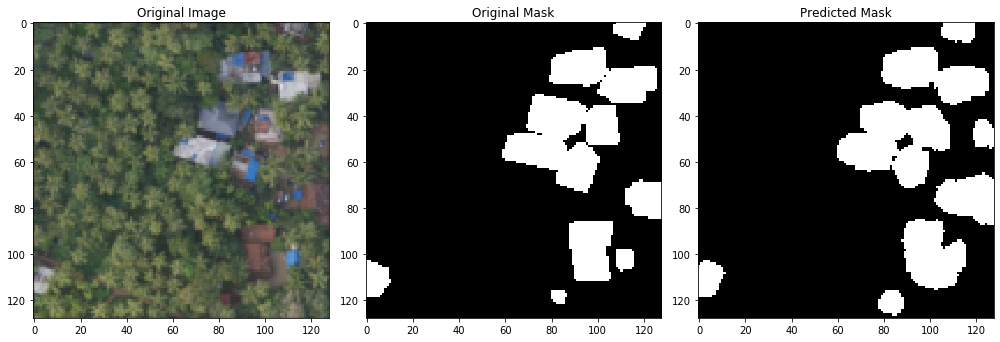

In [0]:
test_img = 4
def pred_img(test_img):
    print(f"{test_img}")
    plt.figure(1)
    plt.figure(figsize=(14,14))
    plt.subplot(131)
    plt.title("Original Image")
    imshow(X_test[test_img])
    plt.subplot(132)
    plt.title("Original Mask")
    imshow(np.squeeze(Y_test[test_img]))
    plt.subplot(133)
    plt.title("Predicted Mask")
    imshow(np.squeeze(preds_test_t[test_img]))
    plt.show()
pred_img(test_img)

16


<Figure size 432x288 with 0 Axes>

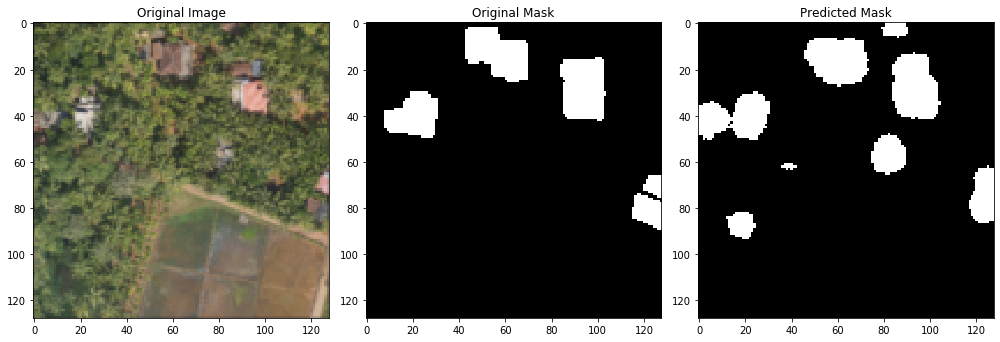

In [0]:
test_img= 16
pred_img(test_img)